In [2]:
import os
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch

from matplotlib import rcParams
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

np.random.seed(2024)

In [4]:
df_train = pd.read_csv("data/train.csv")
df_train.describe()

,message,label
count,25000,25000
unique,24904,2
top,How has this piece of crap stayed on TV this l...,neg
freq,3,12500


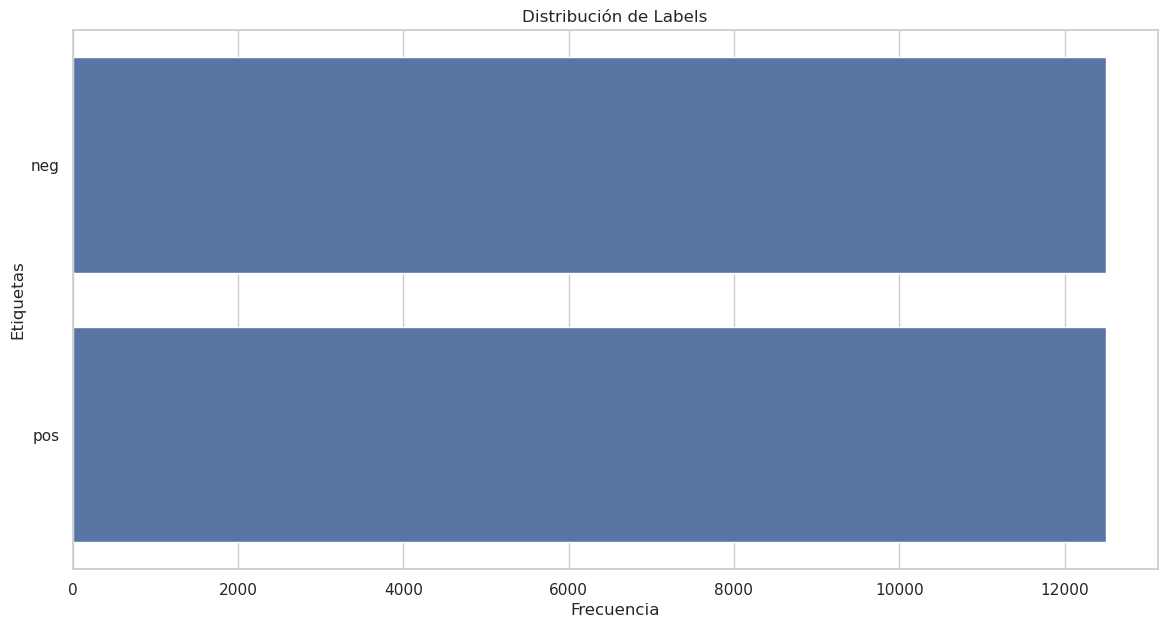

In [7]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))
sns.countplot(df_train.iloc[:, 1], order=df_train.iloc[:, 1].value_counts().index)

# Configurar los títulos y etiquetas
plt.title('Distribución de Labels')
plt.xlabel('Frecuencia')
plt.ylabel('Etiquetas')

# Mostrar la gráfica
plt.show()